In [1]:
pip install opencv-python


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
import os
from fastai.vision.all import *
from nbdev.showdoc import *
import fastbook
fastbook.setup_book()
import random
from fastai.vision.augment import aug_transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from fastai.data.load import DataLoader
from imblearn.over_sampling import RandomOverSampler
import cv2
import numpy as np
from fastai.vision.all import *
import math
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

2024-06-15 10:40:16.343367: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-15 10:40:16.402575: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 10:40:17.257464: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
def _compute_otsu_criteria(im, th):
    # create the thresholded image
    thresholded_im = np.zeros(im.shape)
    thresholded_im[im >= th] = 1

    # compute weights
    nb_pixels = im.size
    nb_pixels1 = np.count_nonzero(thresholded_im)
    weight1 = nb_pixels1 / nb_pixels
    weight0 = 1 - weight1

    # if one of the classes is empty, eg all pixels are below or above the threshold, that threshold will not be considered
    # in the search for the best threshold
    if weight1 == 0 or weight0 == 0:
        return np.inf

    # find all pixels belonging to each class
    val_pixels1 = im[thresholded_im == 1]
    val_pixels0 = im[thresholded_im == 0]

    # compute variance of these classes
    var1 = np.var(val_pixels1) if len(val_pixels1) > 0 else 0
    var0 = np.var(val_pixels0) if len(val_pixels0) > 0 else 0

    return weight0 * var0 + weight1 * var1

In [5]:
def otsuThresholding(img: np.ndarray) -> np.ndarray:
    threshold_range = range(np.max(img)+1)
    criterias = np.array([_compute_otsu_criteria(img, th) for th in threshold_range])

    # best threshold is the one minimizing the Otsu criteria
    best_threshold = threshold_range[np.argmin(criterias)]

    binary = img
    binary[binary > best_threshold] = 255
    binary[binary <= best_threshold] = 0

    return binary

In [6]:
bac_minus_folder = 'NEGATIVOS'
bac_plus_folder = 'POSITIVOS'

bac_minus_paths = get_image_files(bac_minus_folder)
bac_plus_paths = get_image_files(bac_plus_folder)

bac_minus_labels = [0] * len(bac_minus_paths)
bac_plus_labels = [1] * len(bac_plus_paths)

all_paths = list(bac_minus_paths) + list(bac_plus_paths)
all_labels = bac_minus_labels + bac_plus_labels

train_paths, valid_paths, train_labels, valid_labels = train_test_split(all_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

train_df = pd.DataFrame({'image_path': train_paths, 'label': train_labels})
valid_df = pd.DataFrame({'image_path': valid_paths, 'label': valid_labels})



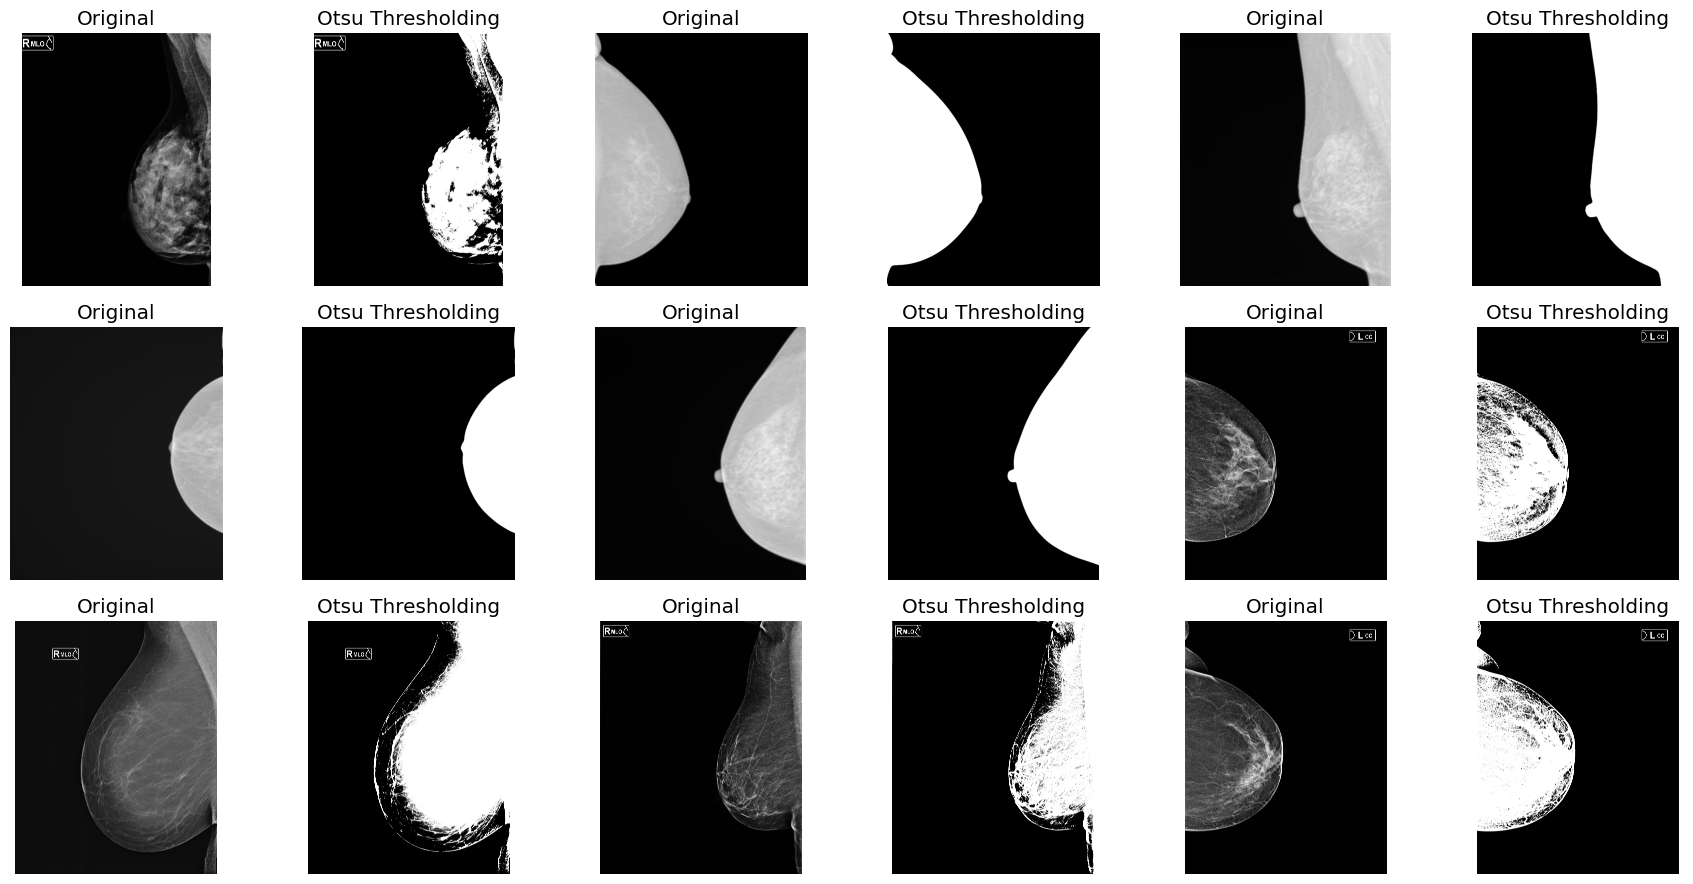

In [8]:
from PIL import Image

random_indices = np.random.randint(0, len(train_df), size=9)
sample_images = train_df.iloc[random_indices]

def plot_images_with_otsu(sample_images):
    fig, axes = plt.subplots(3, 6, figsize=(18, 9))

    for i, (_, row) in enumerate(sample_images.iterrows()):
        image_path = row['image_path']
        image = Image.open(image_path).convert('L')
        img_np = np.array(image)

        axes[i // 3, 2 * (i % 3)].imshow(img_np, cmap='gray')
        axes[i // 3, 2 * (i % 3)].set_title('Original')
        axes[i // 3, 2 * (i % 3)].axis('off')

        otsu_img = otsuThresholding(img_np)
        axes[i // 3, 2 * (i % 3) + 1].imshow(otsu_img, cmap='gray')
        axes[i // 3, 2 * (i % 3) + 1].set_title('Otsu Thresholding')
        axes[i // 3, 2 * (i % 3) + 1].axis('off')

    plt.tight_layout()
    plt.show()

plot_images_with_otsu(sample_images)